# Logistic Regression
> Predict aircraft damage based on columns and see which columns affect it more

### Import libraries

In [14]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set() 
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV

In [15]:
aviation = pd.read_csv('../Data/AviationFinal.csv')

### Encode categorical values 

In [16]:
# Use get dummies to encode categorical values 
weatherCondition = pd.get_dummies(aviation["WeatherCondition"], prefix_sep='_', drop_first=True)
phase = pd.get_dummies(aviation["BroadPhaseOfFlight"], prefix_sep='_', drop_first=True)
purposeOfFlight = pd.get_dummies(aviation["PurposeOfFlight"], prefix_sep='_', drop_first=True)
engineType = pd.get_dummies(aviation["EngineType"], prefix_sep='_', drop_first=True)
month = aviation["Month"]
aircraftDamage = pd.get_dummies(aviation["AircraftDamage"], prefix_sep='_', drop_first=True)

### Combine all columns to predict aircraft damage and split into test and train

In [17]:
weatherCondition.reset_index(drop=True, inplace=True)
phase.reset_index(drop=True, inplace=True)
purposeOfFlight.reset_index(drop=True, inplace=True)
engineType.reset_index(drop=True, inplace=True)
month.reset_index(drop=True, inplace=True)

train = pd.concat([weatherCondition, phase, purposeOfFlight, engineType, month],axis=1)
train_y = aviation["AircraftDamage"]
train

UNK  VMC  CLIMB  CRUISE  DESCENT  GO-AROUND  LANDING  MANEUVERING  \
0        1    0      0       0        0          0        0            1   
1        0    1      0       0        0          0        1            0   
2        0    1      0       0        0          0        0            0   
3        0    1      0       0        0          0        0            1   
4        0    1      0       0        0          0        0            0   
...    ...  ...    ...     ...      ...        ...      ...          ...   
79136    0    1      0       0        0          0        0            0   
79137    0    0      0       1        0          0        0            0   
79138    0    0      0       1        0          0        0            0   
79139    1    0      0       0        0          0        0            0   
79140    1    0      0       1        0          0        0            0   

       OTHER  STANDING  ...  REC, TJ, TJ  Reciprocating  TF, TJ  \
0          0         0  ...            0              0       0   
1          0         0  ...            0              0       0   
2          0         0  ...            0              1       0   
3          0         0  ...            0              1       0   
4          0         0  ...            0              1       0   
...      ...       ...  ...          ...            ...     ...   
79136      0         0  ...            0              0       0   
79137      0         0  ...            0              1       0   
79138      0         0  ...            0              1       0   
79139      0         0  ...            0              1       0   
79140      0         0  ...            0              1       0   

       TJ, REC, REC, TJ  Turbo Fan  Turbo Jet  Turbo Prop  Turbo Shaft  \
0                     0          0          0           0            1   
1                     0          0          0           0            0   
2                     0          0          0           0            0   
3                     0          0          0           0            0   
4                     0          0          0           0            0   
...                 ...        ...        ...         ...          ...   
79136                 0          0          0           0            0   
79137                 0          0          0           0            0   
79138                 0          0          0           0            0   
79139                 0          0          0           0            0   
79140                 0          0          0           0            0   

       Unknown  Month  
0            0     11  
1            1     11  
2            0     11  
3            0     12  
4            0     12  
...        ...    ...  
79136        1      2  
79137        0      6  
79138        0      8  
79139        0      7  
79140        0     10  

[79141 rows x 48 columns]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(train, train_y, test_size=0.30)

### Fit into logistic regression model

In [19]:
logreg = LogisticRegression(solver='lbfgs', max_iter = 2828, multi_class="multinomial")
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2828,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Print accuracy scores

In [20]:
predictions = logreg.predict(X_test)
print(classification_report(y_test,predictions))
score = logreg.score(X_test, y_test)
print("Mean Accuracy: ", score)

              precision    recall  f1-score   support

   Destroyed       0.56      0.21      0.31      5226
       Minor       0.34      0.07      0.12       720
 Substantial       0.77      0.95      0.85     17096
     Unknown       0.43      0.29      0.34       701

    accuracy                           0.74     23743
   macro avg       0.53      0.38      0.41     23743
weighted avg       0.70      0.74      0.70     23743

Mean Accuracy:  0.7444299372446616


## Recursive Feature Elimination with Cross-validation
> To find out the rankings of columns and optimal number of columns. 

Optimal number of features : 28


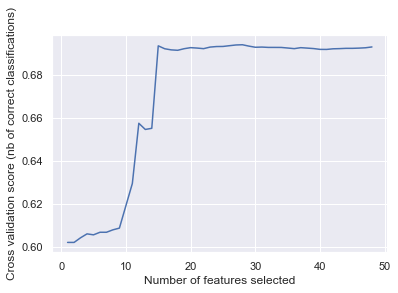

In [21]:
rfecv = RFECV(estimator=logreg, step=1, scoring='f1_weighted', cv = StratifiedKFold(10))
rfecv.fit(train, train_y)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

### Drop non-important features

In [22]:
X_train.drop(X_train.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace = True)
X_test.drop(X_test.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace = True)

In [23]:
print(X_train.columns)
print(X_test.columns)

Index(['UNK', 'VMC', 'CLIMB', 'CRUISE', 'DESCENT', 'LANDING', 'MANEUVERING',
       'OTHER', 'STANDING', 'TAXI', 'Air Race/Show', 'Banner Tow',
       'External Load', 'Ferry', 'Glider Tow', 'Other Work Use',
       'Public Aircraft - Federal', 'Public Aircraft - Local',
       'Public Aircraft - State', 'Unknown', 'None', 'Reciprocating', 'TF, TJ',
       'TJ, REC, REC, TJ', 'Turbo Fan', 'Turbo Jet', 'Turbo Shaft', 'Unknown'],
      dtype='object')
Index(['UNK', 'VMC', 'CLIMB', 'CRUISE', 'DESCENT', 'LANDING', 'MANEUVERING',
       'OTHER', 'STANDING', 'TAXI', 'Air Race/Show', 'Banner Tow',
       'External Load', 'Ferry', 'Glider Tow', 'Other Work Use',
       'Public Aircraft - Federal', 'Public Aircraft - Local',
       'Public Aircraft - State', 'Unknown', 'None', 'Reciprocating', 'TF, TJ',
       'TJ, REC, REC, TJ', 'Turbo Fan', 'Turbo Jet', 'Turbo Shaft', 'Unknown'],
      dtype='object')


### Fit into logistic regression again with important features

In [24]:
logRegv2 = LogisticRegression(solver='lbfgs', max_iter = 2828, multi_class="multinomial")
logRegv2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2828,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Print accuracy scores 

In [25]:
prediction = logRegv2.predict(X_test)
print(classification_report(y_test,prediction))

score = logRegv2.score(X_test, y_test)
print("Mean Accuracy: ", score)

              precision    recall  f1-score   support

   Destroyed       0.56      0.22      0.32      5226
       Minor       0.36      0.08      0.13       720
 Substantial       0.77      0.95      0.85     17096
     Unknown       0.49      0.23      0.32       701

    accuracy                           0.74     23743
   macro avg       0.54      0.37      0.40     23743
weighted avg       0.70      0.74      0.70     23743

Mean Accuracy:  0.7447668786589732
